Importing libraries and setting up environment

In [1]:
import sympy
sympy.init_printing()
import numpy
import pylab
import h5py



# Governing Equations

Mass conservation

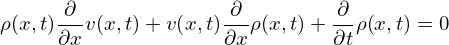

In [2]:
rho = sympy.Function('rho') # Density
v = sympy.Function('v') # Velocity
t = sympy.Symbol('t') # Time
x = sympy.Symbol('x') # Position
mass_conservation = sympy.Eq(sympy.Derivative(rho(x,t), t)+ sympy.Derivative(rho(x,t)*v(x,t),x),0).doit()
mass_conservation

Momentum conservation

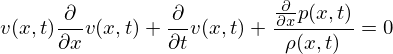

In [3]:
p = sympy.Function('p') # Pressure
momentum_conservation = sympy.Eq(sympy.Derivative(v(x,t),t)+v(x,t)*sympy.Derivative(v(x,t),x)+sympy.Derivative(p(x,t),x)/rho(x,t),0).doit()
momentum_conservation

Entropy conservation

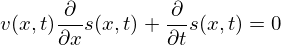

In [4]:
s = sympy.Function('s') # Entropy
entropy_conservation = sympy.Eq(sympy.Derivative(s(x,t),t)+v(x,t)*sympy.Derivative(s(x,t),x),0).doit()
entropy_conservation

Equation of state

In [5]:
gamma = sympy.Symbol('gamma') # Adiabatic index
eos = sympy.Eq(s(x,t), sympy.log(p(x,t))-gamma*sympy.log(rho(x,t)))
eos

# Reduction to dimensionless equations

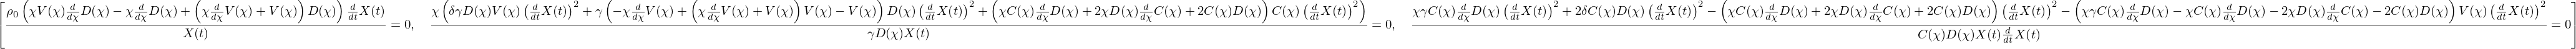

In [6]:
D = sympy.Function('D') # Dimensionless density
rho_0 = sympy.Symbol('rho_0', positive=True) # Upstream density
X = sympy.Function('X') # Position of the shock front
c = sympy.Function('c') # Speed of sound
V = sympy.Function('V') # Dimensionless velocity
C = sympy.Function('C') # Dimensionless speed of sound 
chi = sympy.Symbol('chi') # Dimensionless position
delta = sympy.Symbol('delta') # Shock velocity position power law index
temp = [mass_conservation, momentum_conservation, entropy_conservation.subs(eos.lhs,eos.rhs).doit()]
temp = [itm.subs(p(x,t), rho(x,t)*c(x,t)**2/gamma) for itm in temp]
temp = [itm.subs(rho(x,t), rho_0*D(x/X(t))) for itm in temp]
temp = [itm.subs(v(x,t), X(t).diff(t)*V(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(c(x,t), X(t).diff(t)*C(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(x, chi*X(t)) for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.simplify() for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.subs(X(t).diff(t,2), delta*X(t).diff(t)**2/X(t)) for itm in temp]
dimensionless_equation = temp
dimensionless_equation

solving for the derivatives

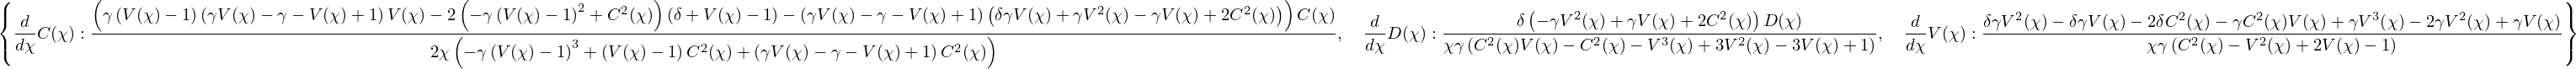

In [7]:
dimles_derivatives = sympy.solve(dimensionless_equation, [v(chi).diff(chi) for v in [D,C,V]])
dimles_derivatives

Safe places to cross the sonic line

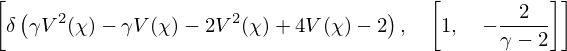

In [8]:
temp = V(chi).diff(chi).subs(dimles_derivatives)
temp = sympy.fraction(temp)[0]
temp = temp.subs(C(chi), 1-V(chi)).simplify()
[temp, sympy.solve(temp, V(chi))]

It is possible to reduce these ODEs in $\chi$ to just one ode of $C$ vs $V$

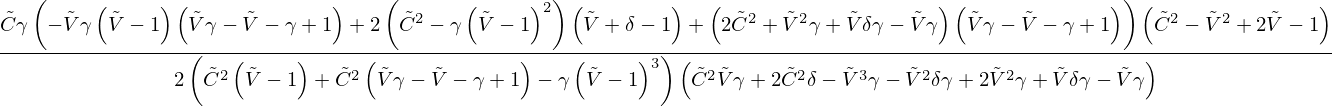

In [9]:
V_tilde = sympy.Symbol(r'\tilde{V}')
C_tilde = sympy.Symbol(r'\tilde{C}')
temp = C(chi).diff(chi)/V(chi).diff(chi)
temp = temp.subs(dimles_derivatives)
temp = temp.subs(V(chi), V_tilde)
temp = temp.subs(C(chi), C_tilde)
temp = temp.simplify()
dCdV = temp
dCdV


In [10]:
dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
alpha = sympy.Symbol('alpha') #slope of dCdv
temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
temp = temp.subs(dVs, 1e-6).subs(delta, -2./3.).subs(gamma, 7./5.)
slope_solve = sympy.solve(temp - alpha, alpha)
slope_solve[0] #great!

In [11]:
dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
alpha = sympy.Symbol('alpha') #slope of dCdv
temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
temp = temp.subs(dVs, 1e-6).subs(delta, -0.6).subs(gamma, 5./3.)
slope_solve = sympy.solve(temp - alpha, alpha)
slope_solve[0] #great!

stuff

General v-tilde derivexpression


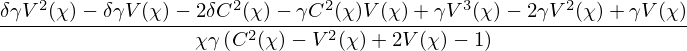

In [12]:
temp = dimles_derivatives[V(chi).diff(chi)]
print("General v-tilde derivexpression")
display(temp)

temp = temp.subs(delta, -2./3.)
temp = temp.subs(gamma, 7./5.)
temp = temp.subs(V(chi), (5.*chi/3. - 5./6.)/chi)
temp = temp.subs(C(chi), (sympy.sqrt(7)*sympy.sqrt(5 - 4*chi))/(6*chi))
temp1 = temp.nsimplify().simplify().subs(chi, -1./2.)
temp1 #seems to be correct!!! now check c...

In [13]:
temp = dimles_derivatives[C(chi).diff(chi)]
#print("General c-tilde deriv expression")
#display(temp)

temp = temp.subs(delta, -2./3.)
temp = temp.subs(gamma, 7./5.)
temp = temp.subs(V(chi), (5.*chi/3. - 5./6.)/chi)
temp = temp.subs(C(chi), (sympy.sqrt(7)*sympy.sqrt(5 - 4*chi))/(6*chi))
temp2 = temp.nsimplify().simplify().subs(chi, -1./2.)
temp2 #yep, c is also right, these are the correct functions.
print("C-tilde deriv:")
display(temp2)
#print("dcdv:")
#temp2/temp1

C-tilde deriv:


Sanity check

In [14]:
temp = sympy.sqrt(sympy.Rational(1,2)*gamma*(gamma-1)*(1-V_tilde)*V_tilde**2/(gamma*V_tilde-1))
temp = dCdV.subs(C_tilde,temp)/temp.diff(V_tilde)
temp = temp.subs(delta,sympy.Rational(-1,2))
temp.simplify()

Slope at the safe sonic point crossing

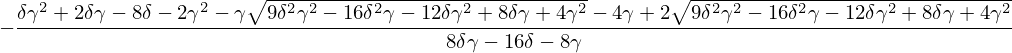

In [15]:
alpha = sympy.Symbol('alpha', positive=True) # Slope
DeltaV = sympy.Symbol(r'\Delta V', positive=True)
temp = dCdV.subs(C_tilde,1-(2/(2-gamma))+alpha*DeltaV)
temp = temp.subs(V_tilde, 2/(2-gamma)+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
sonic_line_slope = sympy.solve(alpha-temp,alpha)[0]
sonic_line_slope


Boundary conditions at the shock front

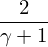

In [16]:
V_shock_front = 2/(gamma+1)
V_shock_front

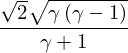

In [17]:
C_shock_front = sympy.sqrt(2*gamma*(gamma-1))/(gamma+1)
C_shock_front

# Shooting method

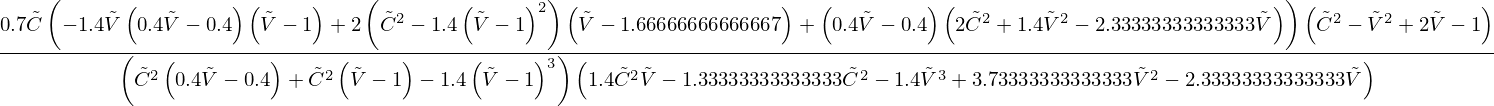

In [18]:
#dCdV.subs({gamma:7./5., V_tilde:10./3. + 1e-1, C_tilde:-7./3. - 1e-1, delta:-2./3.}) 
temp = dCdV.subs({gamma:7./5., delta:-2./3.}) 
temp

<IPython.core.display.Javascript object>


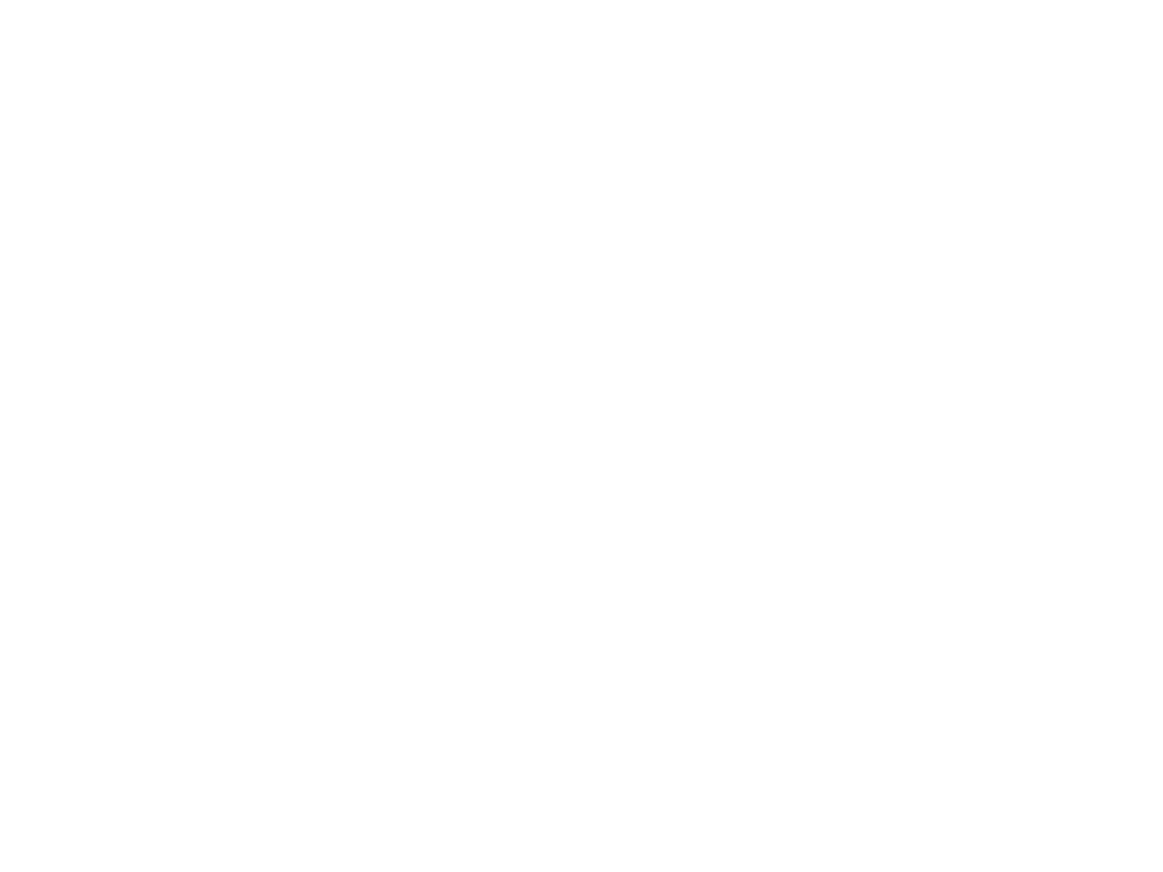

In [19]:
def shoot_from_shock_front(dv, gv):
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    vbc = float(V_shock_front.subs(gamma,gv))
    cbc = float(C_shock_front.subs(gamma,gv))
    v_list = numpy.linspace(vbc, -10.0*vbc,1000)
    c_list = cbc*numpy.ones_like(v_list)
    for n in range(1,len(v_list)):
        dv = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])
    
    # Behind initial impact point
    v_list_2 = numpy.linspace(-v_list[-1],-0.2*v_list[-1], 1000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    for n in range(1, len(v_list_2)):
        dv = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + dv*wrapper(v_list_2[n-1], c_list_2[n-1])
        
    unified_v_list = numpy.concatenate((v_list, [numpy.nan], v_list_2))
    unified_c_list = numpy.concatenate((c_list, [numpy.nan], c_list_2))
    
    return numpy.vstack((unified_v_list, unified_c_list))
%matplotlib notebook
plotfunc = pylab.plot
for dv in numpy.linspace(-0.63,-0.64,5):
    temp = shoot_from_shock_front(dv,5./3.)
    plotfunc(temp[0], temp[1], label=r'$\delta=$'+str(dv))
plotfunc(temp[0], 1-temp[0],'k',label='sonic')
pylab.legend()
pylab.xlabel('V')
pylab.ylabel('C')
pass

-1.08402943675593


<IPython.core.display.Javascript object>


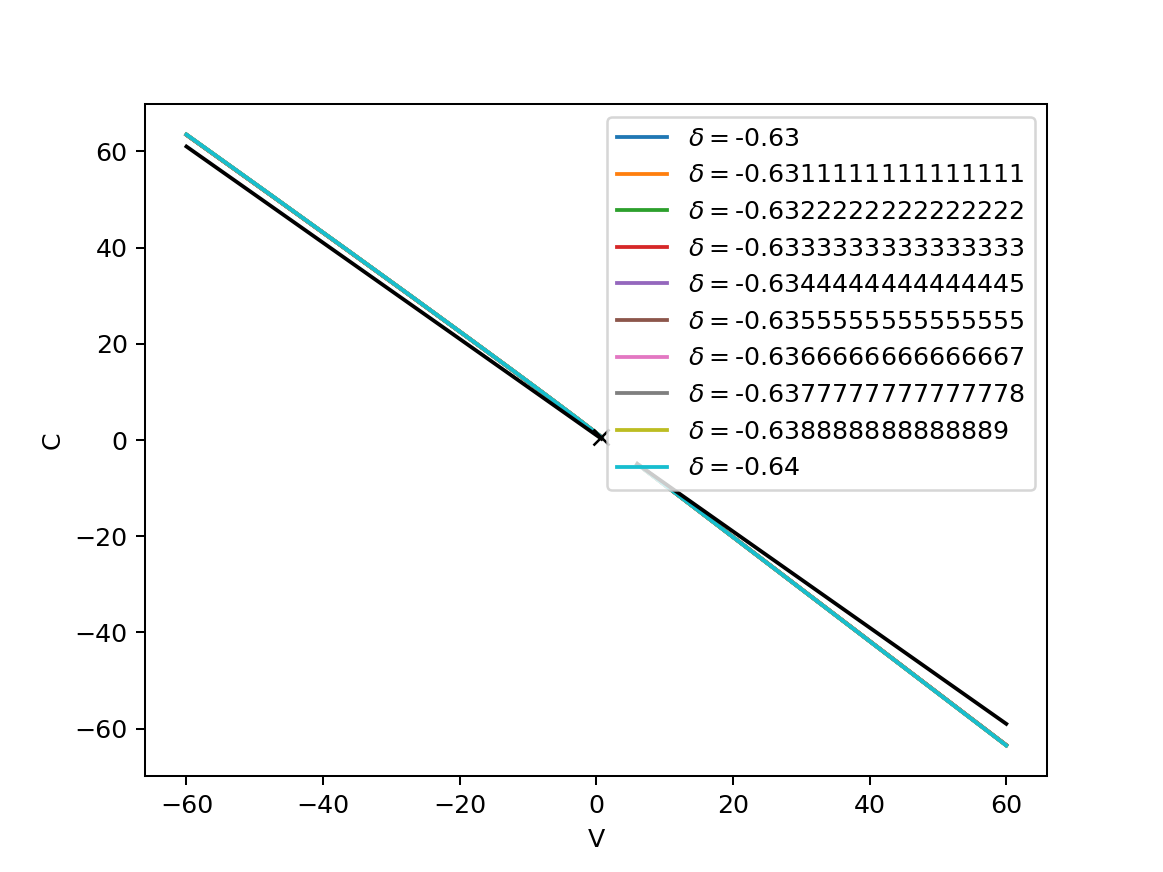

-1.08418424909631
-1.08433909285403
-1.08449391436345
-1.08464884981695
-1.08480380567170
-1.08495880280977
-1.08511382142846
-1.08526890138314
-1.08542402286089


In [30]:
def shoot_from_sonic_point(dv, gv):
    
    deriv_at_sonic = sonic_line_slope.subs({gamma:gv,delta:dv})
    v_jump = 1e-6
    
    #finding slope at sonic
    dVs = sympy.Symbol('dVs') #special difference variable, delta V_sonic
    alpha = sympy.Symbol('alpha') #slope of dCdv
    temp  = dCdV.subs(V_tilde, dVs + 2/(2-gamma)).subs(C_tilde, alpha*dVs - gamma/(2-gamma))
    temp = temp.subs(dVs, 1e-6).subs(gamma, gv).subs(delta, dv)
    slope_solve = sympy.solve(temp - alpha, alpha)
    sonic_slope = slope_solve[0] #great!
    print(sonic_slope)
    V_start = float((2/(2-gamma)).subs(gamma,gv)) + 1e-6
    C_start = float((1-((2/(2-gamma)))).subs(gamma,gv)) + (1e-6) * float(sonic_slope)
    v_list = numpy.linspace(V_start, 10*V_start, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        dv = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + dv*wrapper(v_list[n-1], c_list[n-1])
        
    # Second leg
    vbc = float(V_shock_front.subs(gamma,gv))
    cbc = float(C_shock_front.subs(gamma,gv))    
    v_list_2 = numpy.linspace(-v_list[-1], vbc, 10000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    
    for n in range(1, len(v_list_2)):
        dv = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + dv*wrapper(v_list_2[n-1], c_list_2[n-1])
        
    unified_v_list = numpy.concatenate((v_list,[numpy.nan],v_list_2))
    unified_c_list = numpy.concatenate((c_list,[numpy.nan],c_list_2))
    
    return numpy.vstack((unified_v_list, unified_c_list))

%matplotlib notebook
for dv in numpy.linspace(-0.63,-0.64,10):
    temp = shoot_from_sonic_point(dv, 5./3.)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,5./3.)),
          float(C_shock_front.subs(gamma,5./3.)),'kx')
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel('V')
pylab.ylabel('C')
pylab.legend()

-6.16889478878912


<IPython.core.display.Javascript object>


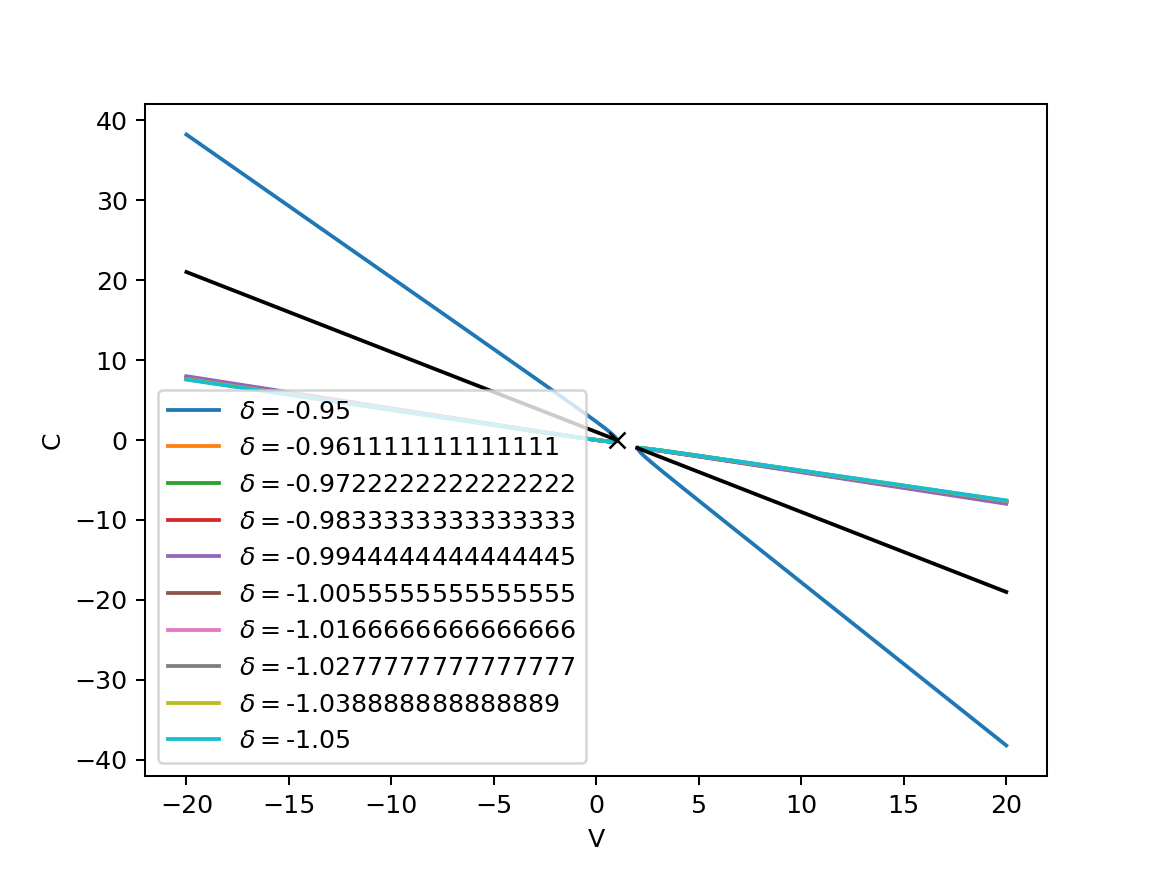

-7.61280118066634
-10.2007987595065
-16.2186377825275
-46.2342125741506
0.0114294351829507
0.0364579000117277
0.0650595402642707
0.0984190001291298
0.138440463746412


In [36]:
%matplotlib notebook 
#1 case is weird.
for dv in numpy.linspace(-0.95,-1.05,10):
    temp = shoot_from_sonic_point(dv, 1.)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,1.)),
          float(C_shock_front.subs(gamma,1.)),'kx')
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel('V')
pylab.ylabel('C')
pylab.legend() #gamma -> 1 case is weird...

-1.60597031479291


<IPython.core.display.Javascript object>


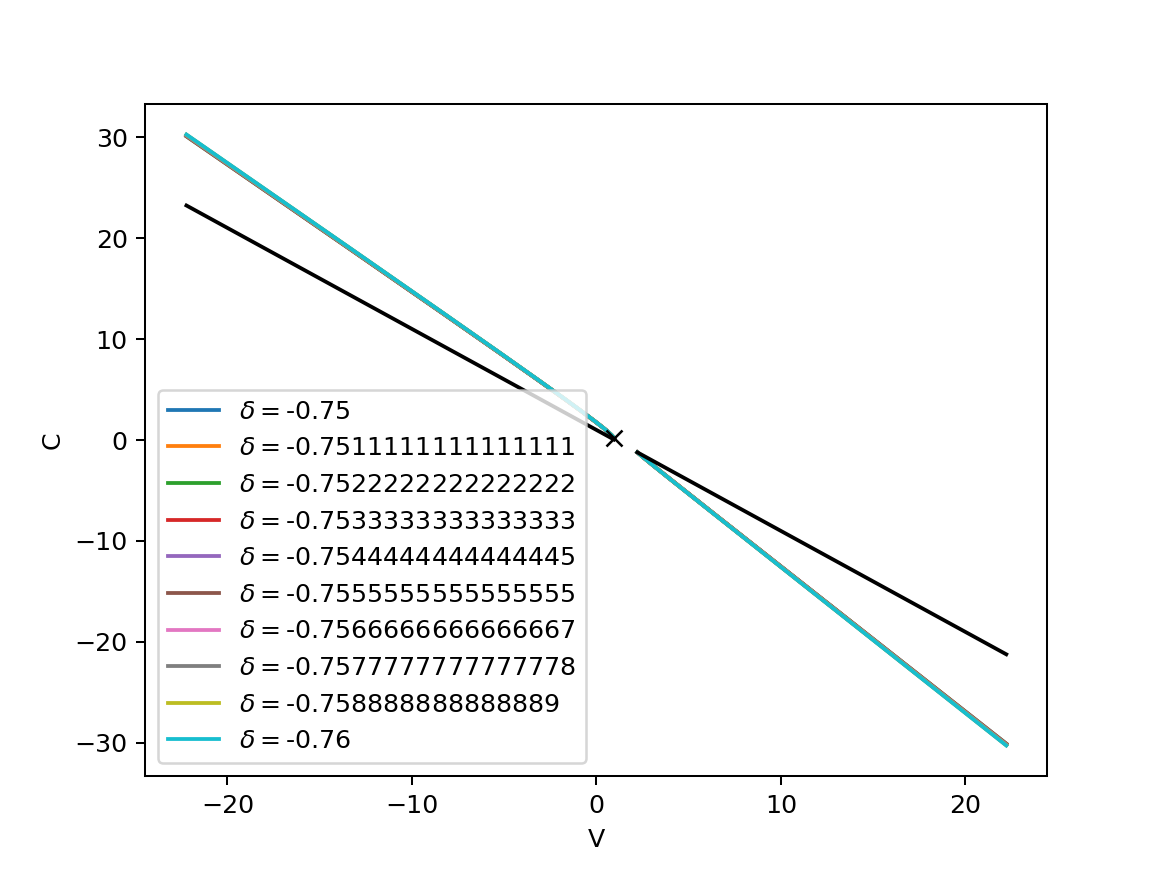

-1.60797714450168
-1.60999238994373
-1.61201609625730
-1.61404833157389
-1.61608916101223
-1.61813862955729
-1.62019680833039
-1.62226375311383
-1.62433952696501


In [33]:
%matplotlib notebook 
#1.1 case
for dv in numpy.linspace(-0.75,-0.76,10):
    temp = shoot_from_sonic_point(dv, 1.1)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,1.1)),
          float(C_shock_front.subs(gamma,1.1)),'kx')
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel('V')
pylab.ylabel('C')
pylab.legend() #a bit off still? should give delta = -0.7574... according to Zeldovich, but it is between -0.757 and -0.758

-1.17572625392326


<IPython.core.display.Javascript object>


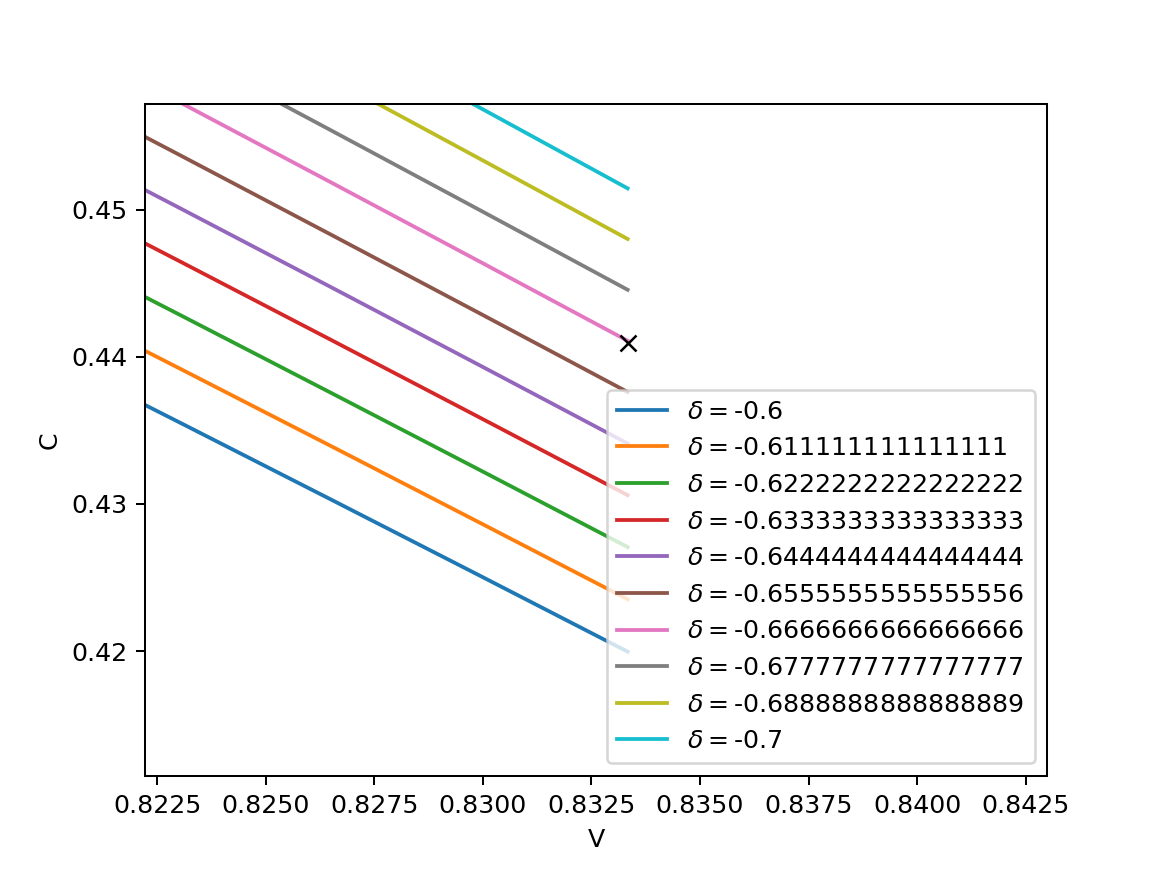

-1.17967468668253
-1.18366083491095
-1.18768556885980
-1.19174972985158
-1.19585424339666
-1.19999998142841
-1.20418789027616
-1.20841890580382
-1.21269401433848


In [27]:
%matplotlib notebook 
#7/5 case
for dv in numpy.linspace(-0.6,-0.7,10):
    temp = shoot_from_sonic_point(dv, 7./5.)
    pylab.plot(temp[0], temp[1], label=r'$\delta=$'+str(dv))
pylab.plot(float(V_shock_front.subs(gamma,7./5.)),
          float(C_shock_front.subs(gamma,7./5.)),'kx')
pylab.plot(temp[0],1-temp[0],'k')
pylab.xlabel('V')
pylab.ylabel('C')
pylab.legend() #good

<string>:2: RuntimeWarning: divide by zero encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/3-5.3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


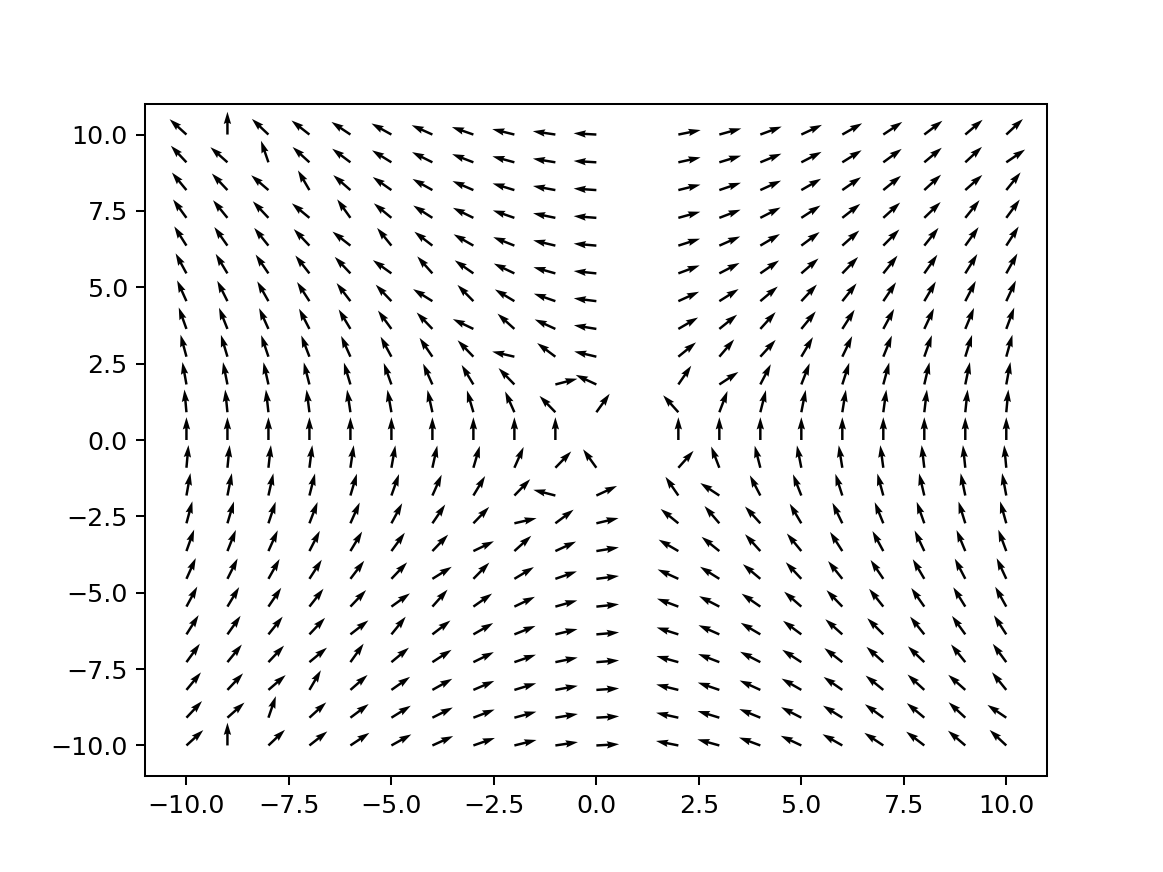

In [24]:
def phase_space_plot(dv, gv):
    
    v_list = numpy.linspace(-10,10,21)
    c_list = numpy.linspace(-10,10,23)
    V_list, C_list = numpy.meshgrid(v_list, c_list)
    deriv = dCdV.subs({gamma:gv, delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    slopes = wrapper(V_list, C_list)
    SV_list = slopes/numpy.sqrt(slopes**2+1)
    SC_list = 1.0/numpy.sqrt(slopes**2+1)
    %matplotlib notebook
    pylab.quiver(V_list, C_list, SV_list, SC_list)
    
    return None
phase_space_plot(-0.62, 5./3.)